# A study on sampled networkx with 5.3K nodes
The networkx is sampled using a random walk with flying back method
when Evaluating a sample, we want to do the following:
1. comapre basic properties including: average degree, average strength. Must include visulization testing power law on degree and strength
2. a clustering coef vs degree plot 

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
import random
import utils
from collections import defaultdict
import os

import seaborn as sns
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,DBSCAN

In [2]:
G_sample = nx.read_edgelist('data/RWMult_sample5.3K.edgelist', data=(("total",float),("count", int)), create_using=nx.DiGraph)
# some basic properties
utils.print_basic_properties(G_sample)

Number of nodes: 5201
Number of edges: 33678
Average degree: 12.950586425687368
Average clustering coefficient: 0.01630735040785356


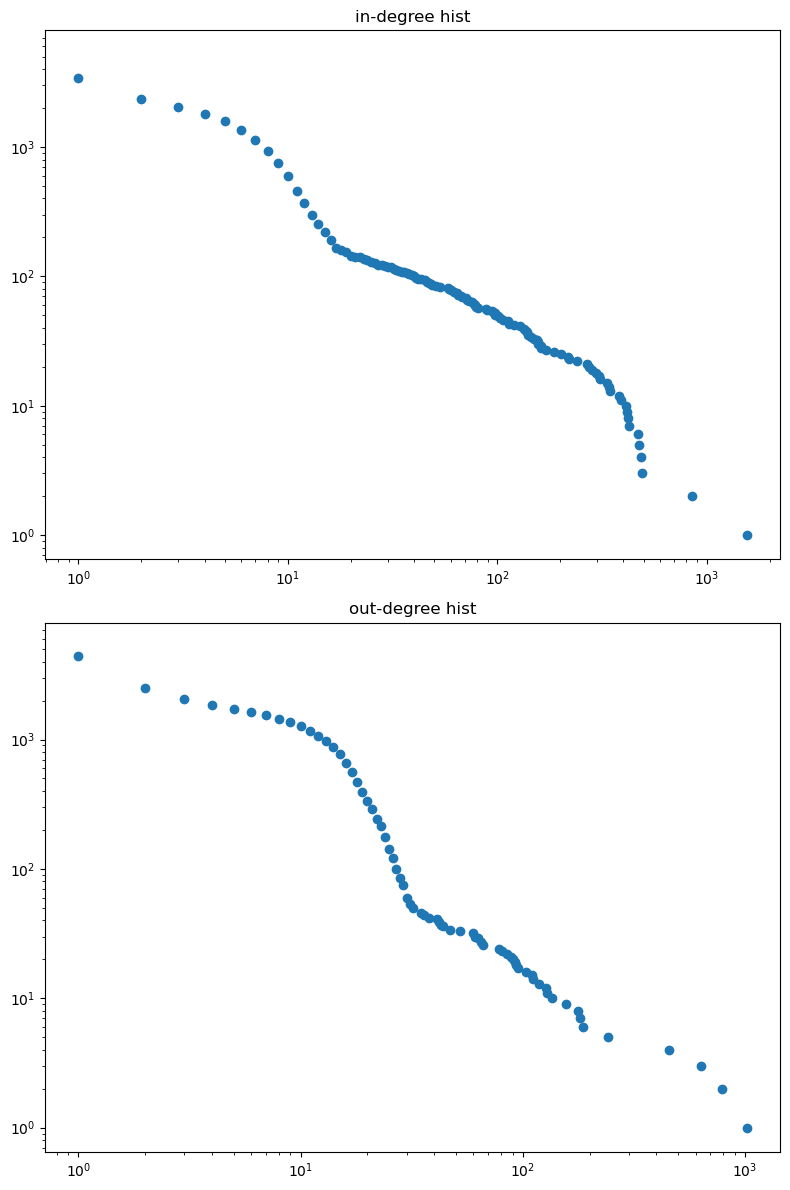

In [3]:
utils.degree_scatter(G_sample,['in','out'],type='count',log=True)

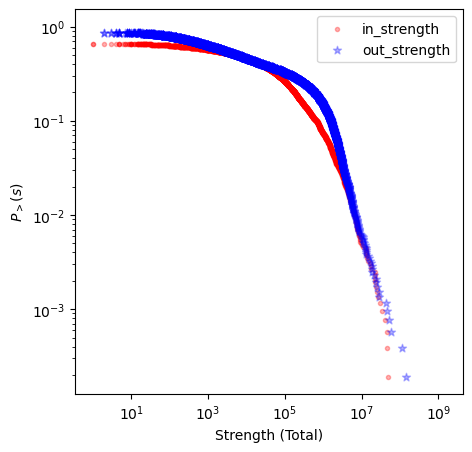

In [4]:
utils.strength_scatter(G_sample,figsize=(5,5))

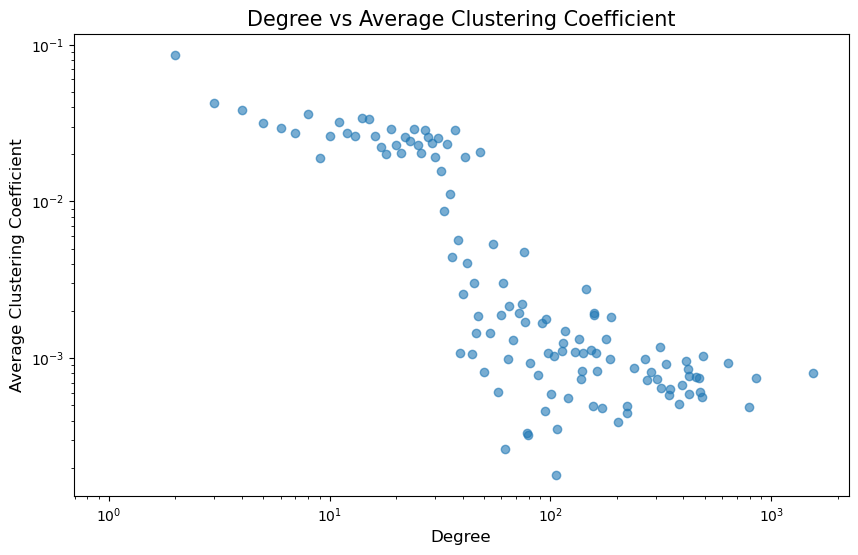

In [5]:
utils.degree_vs_avgclustering(G_sample)

## Generate node fetures table from networkx object

In [6]:
def get_features(G):
    node_features = {}
    for node in G.nodes():
        in_edges = G.in_edges(node, data=True)
        out_edges = G.out_edges(node, data=True)
        
        in_degree = G.in_degree(node)
        out_degree = G.out_degree(node)
        
        in_strength_total = sum(data['total'] for _, _, data in in_edges)
        out_strength_total = sum(data['total'] for _, _, data in out_edges)
        
        in_strength_count = sum(data['count'] for _, _, data in in_edges)
        out_strength_count = sum(data['count'] for _, _, data in out_edges)
        
        clustering_coefficient = nx.clustering(G.to_undirected(), node)
        
        node_features[node] = [
            in_degree, 
            out_degree, 
            in_strength_total, 
            out_strength_total, 
            in_strength_count, 
            out_strength_count, 
            clustering_coefficient
        ]
    node_features_df = pd.DataFrame.from_dict(node_features,orient='index',
                                              columns=[
            'in_degree', 
            'out_degree', 
            "in_strength_total", 
            'out_strength_total', 
            'in_strength_count', 
            'out_strength_count', 
            "clustering_coefficient"
        ])
    return node_features_df

file_path = 'data/node_features.csv'
if os.path.exists(file_path):
    # Read the file
    node_feature_df = pd.read_csv(file_path)
    
else:
    # Create the file
    node_feature_df = get_features(G_sample)
    node_feature_df.to_csv(file_path, index=False)


In [7]:
node_feature_df = node_feature_df[[
            'in_degree', 
            'out_degree', 
            "in_strength_total", 
            'out_strength_total', 
            'in_strength_count', 
            'out_strength_count', 
        ]]

inertia = []
scaler = StandardScaler()
data = node_feature_df.values
normalized_features = scaler.fit_transform(data)

## try different clsutersing in k means

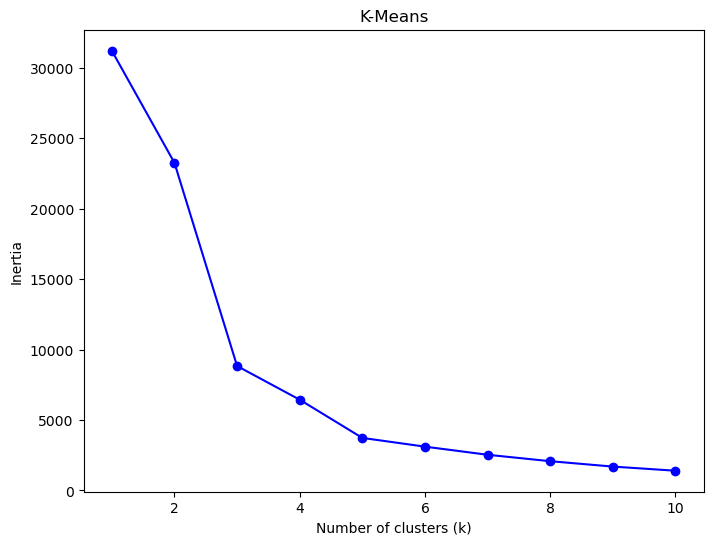

In [8]:
K = range(1, 11)  # Change range as needed

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('K-Means')
plt.show()

### Decide the n_cluster and see the result

In [77]:
kmeans = KMeans(n_clusters=3)  # Change n_clusters to your desired number of clusters
kmeans.fit(data)
labels = kmeans.labels_
node_feature_df['cluster'] = labels

In [ ]:
unique_values, counts = np.unique(labels, return_counts=True)
# Combine the unique values and counts into a dictionary for easier interpretation
unique_counts = dict(zip(unique_values, counts))
print(unique_counts)

#### visualize the cluster distribution and k-measn result

In [ ]:
node_feature_df['cluster'] = node_feature_df['cluster'].astype('category')
ax = sns.histplot(node_feature_df, x='cluster', log_scale=(False, True))
# node_feature_df['cluster'].hist(log=True, grid=False)
plt.xlabel('Cluster Label')
plt.ylabel('Number of Account')
plt.title('Node Attribute Clustering Histogram')
ax.set_xticks(range(len(node_feature_df['cluster'].cat.categories)))
ax.set_xticklabels(node_feature_df['cluster'].cat.categories)

plt.show()

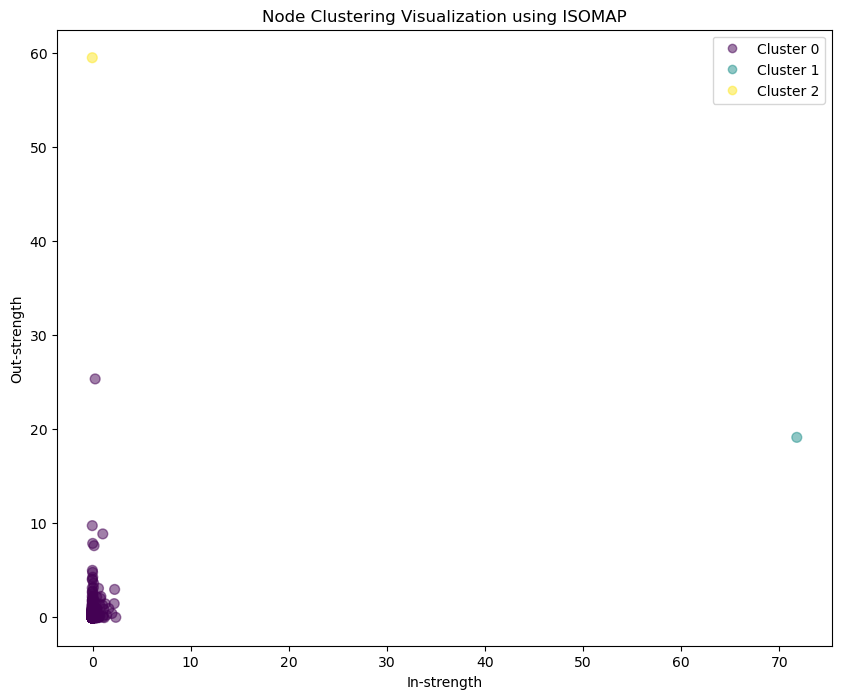

In [83]:

plt.figure(figsize=(10, 8))
scatter = plt.scatter(normalized_features[:,2], normalized_features[:,3], c=labels, cmap='viridis', s=50,alpha=0.5)
plt.title('Node Clustering Visualization using ISOMAP')
plt.xlabel('In-strength')
plt.ylabel('Out-strength')
# plt.xscale('log',base=10)
# plt.yscale('log',base = 10)
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(6)])
plt.show()

Since we observed this very unbalanced cluster distribution, let's sample 150 nodes from cluster 1 and draw ths isomap again


In [80]:

indices_cluster_0 = np.where(labels == 0)[0]
sampled_indices_cluster_0 = np.random.choice(indices_cluster_0, size=150, replace=False)
indices_not_cluster_0 = np.where(labels != 0)[0]
final_indices = np.concatenate([sampled_indices_cluster_0, indices_not_cluster_0])
filtered_features =  normalized_features[final_indices]


In [82]:
features = [
            'in_degree', 
            'out_degree', 
            "in_strength_total", 
            'out_strength_total', 
            'in_strength_count', 
            'out_strength_count', 
            "clustering_coefficient",
        ]
filtered_features_df = pd.DataFrame(filtered_features,columns=features)
filtered_labels = labels[final_indices]
filtered_features_df['cluster'] = filtered_labels

ax = sns.pairplot(filtered_features_df, vars=features[:5], hue='cluster')
ax.add_legend()
plt.show()

ValueError: Shape of passed values is (152, 6), indices imply (152, 7)

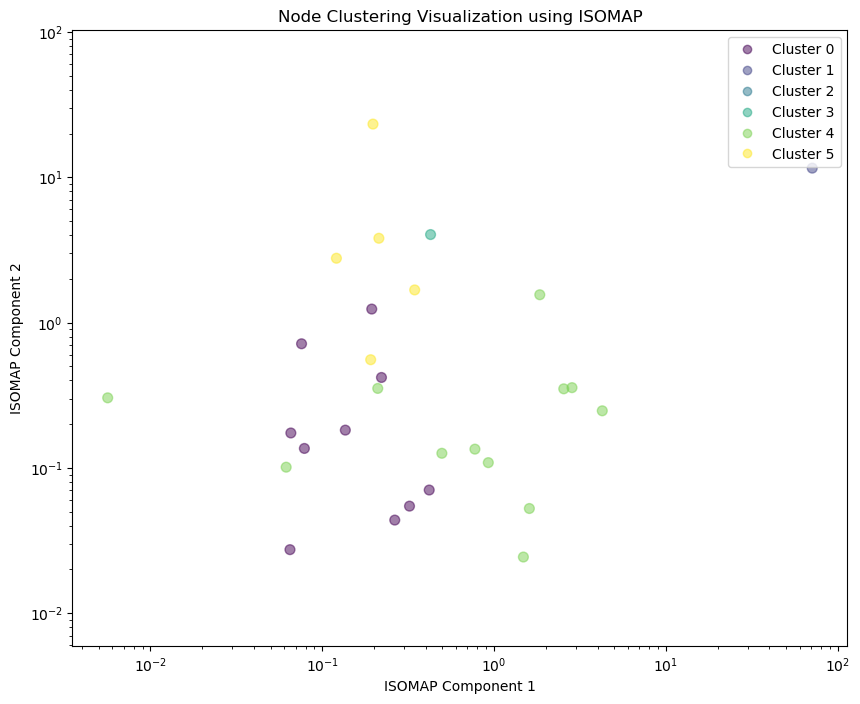

In [26]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(filtered_features[:,4], filtered_features[:,5], c=filtered_labels, cmap='viridis', s=50,alpha=0.5)
plt.title('Node Clustering Visualization using ISOMAP')
plt.xlabel('ISOMAP Component 1')
plt.ylabel('ISOMAP Component 2')
plt.xscale('log',base=10)
plt.yscale('log',base=10)
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(6)])

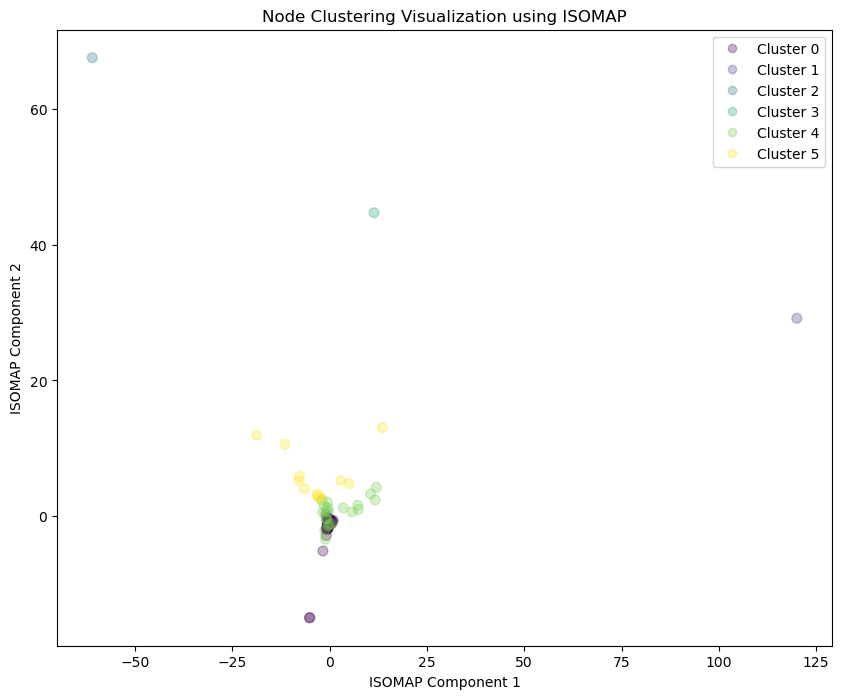

In [27]:
isomap = Isomap(n_components=2)
filtered_isomap = isomap.fit_transform(filtered_features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(filtered_isomap[:,0], filtered_isomap[:,1], c=labels[final_indices], cmap='viridis', s=50,alpha=0.3)
plt.title('Node Clustering Visualization using ISOMAP')
plt.xlabel('ISOMAP Component 1')
plt.ylabel('ISOMAP Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(6)])

## try DBSCAN
DBSCAN is better

In [8]:
model = DBSCAN()
model.fit(normalized_features)
labels = model.labels_


In [9]:
unique_values, counts = np.unique(labels, return_counts=True)
# Combine the unique values and counts into a dictionary for easier interpretation
unique_counts = dict(zip(unique_values, counts))
print(unique_counts)

{-1: 93, 0: 5108}


d:\Anaconda\envs\network\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


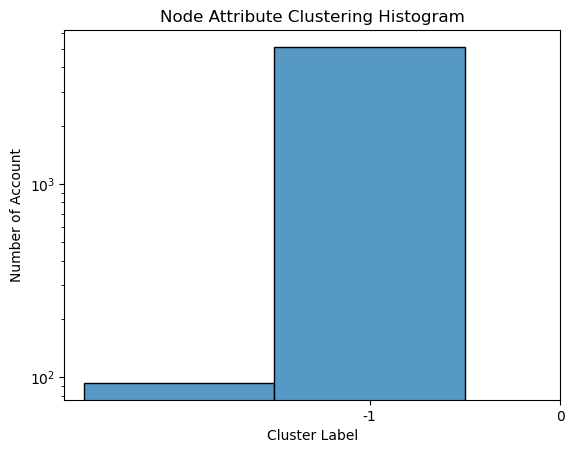

In [10]:
node_feature_df['cluster'] = labels
node_feature_df['cluster'] = node_feature_df['cluster'].astype('category')
ax = sns.histplot(node_feature_df, x='cluster', log_scale=(False, True))
# node_feature_df['cluster'].hist(log=True, grid=False)
plt.xlabel('Cluster Label')
plt.ylabel('Number of Account')
plt.title('Node Attribute Clustering Histogram')
ax.set_xticks(range(len(node_feature_df['cluster'].cat.categories)))
ax.set_xticklabels(node_feature_df['cluster'].cat.categories)

plt.show()

In [19]:
node_feature_df.groupby('cluster')[features].mean()


C:\Users\Longtao\AppData\Local\Temp\ipykernel_18684\2319823352.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  node_feature_df.groupby('cluster')[features].mean()


,in_degree,out_degree,in_strength_total,out_strength_total,in_strength_count,out_strength_count
cluster,,,,,,
-1,154.311828,74.451613,2.303746e+07,1.312680e+07,9833.096774,6065.268817
0,3.783673,5.237666,2.556336e+05,4.360743e+05,162.325568,230.925411


In [20]:
node_feature_df.groupby('cluster')[features].std()

C:\Users\Longtao\AppData\Local\Temp\ipykernel_18684\2696126319.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  node_feature_df.groupby('cluster')[features].std()


,in_degree,out_degree,in_strength_total,out_strength_total,in_strength_count,out_strength_count
cluster,,,,,,
-1,217.378801,153.293588,1.525648e+08,4.099140e+07,47896.608741,29113.154055
0,7.663625,6.909914,8.891938e+05,1.079158e+06,523.850891,449.455933


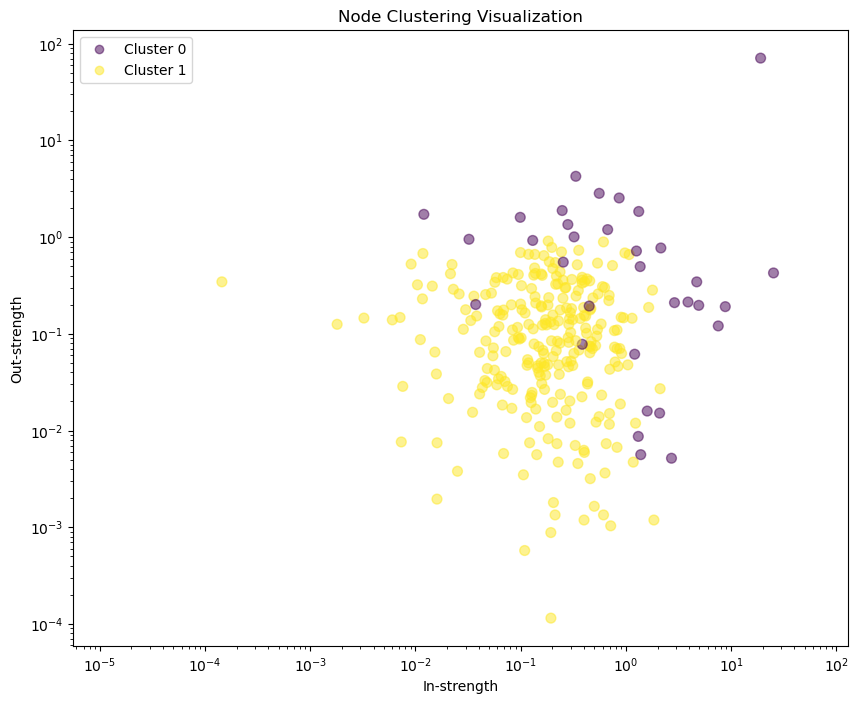

In [19]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(normalized_features[:,3], normalized_features[:,4], c=labels, cmap='viridis', s=50,alpha=0.5)
plt.title('Node Clustering Visualization')
plt.xlabel('In-strength')
plt.ylabel('Out-strength')
plt.xscale('log',base=10)
plt.yscale('log',base = 10)
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(6)])
plt.show()

In [24]:
features = [
            'in_degree', 
            'out_degree', 
            "in_strength_total", 
            'out_strength_total', 
            'in_strength_count', 
            'out_strength_count', 
        ]
normalized_features_df = pd.DataFrame(normalized_features,columns=features)
normalized_features_df['cluster'] = labels


In [ ]:
g = sns.PairGrid(normalized_features_df)

# Map the plots to the PairGrid
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde_kws={'cut': 2})

# Set logarithmic scale for each axis in each subplot
for ax in g.axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')

# Adjust the layout
plt.tight_layout()
plt.show()

In [32]:
clusters = data['cluster'].unique()
clusters

array([ 0, -1], dtype=int64)

d:\Anaconda\envs\network\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\network\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\network\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Anaconda\envs\network\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\network\

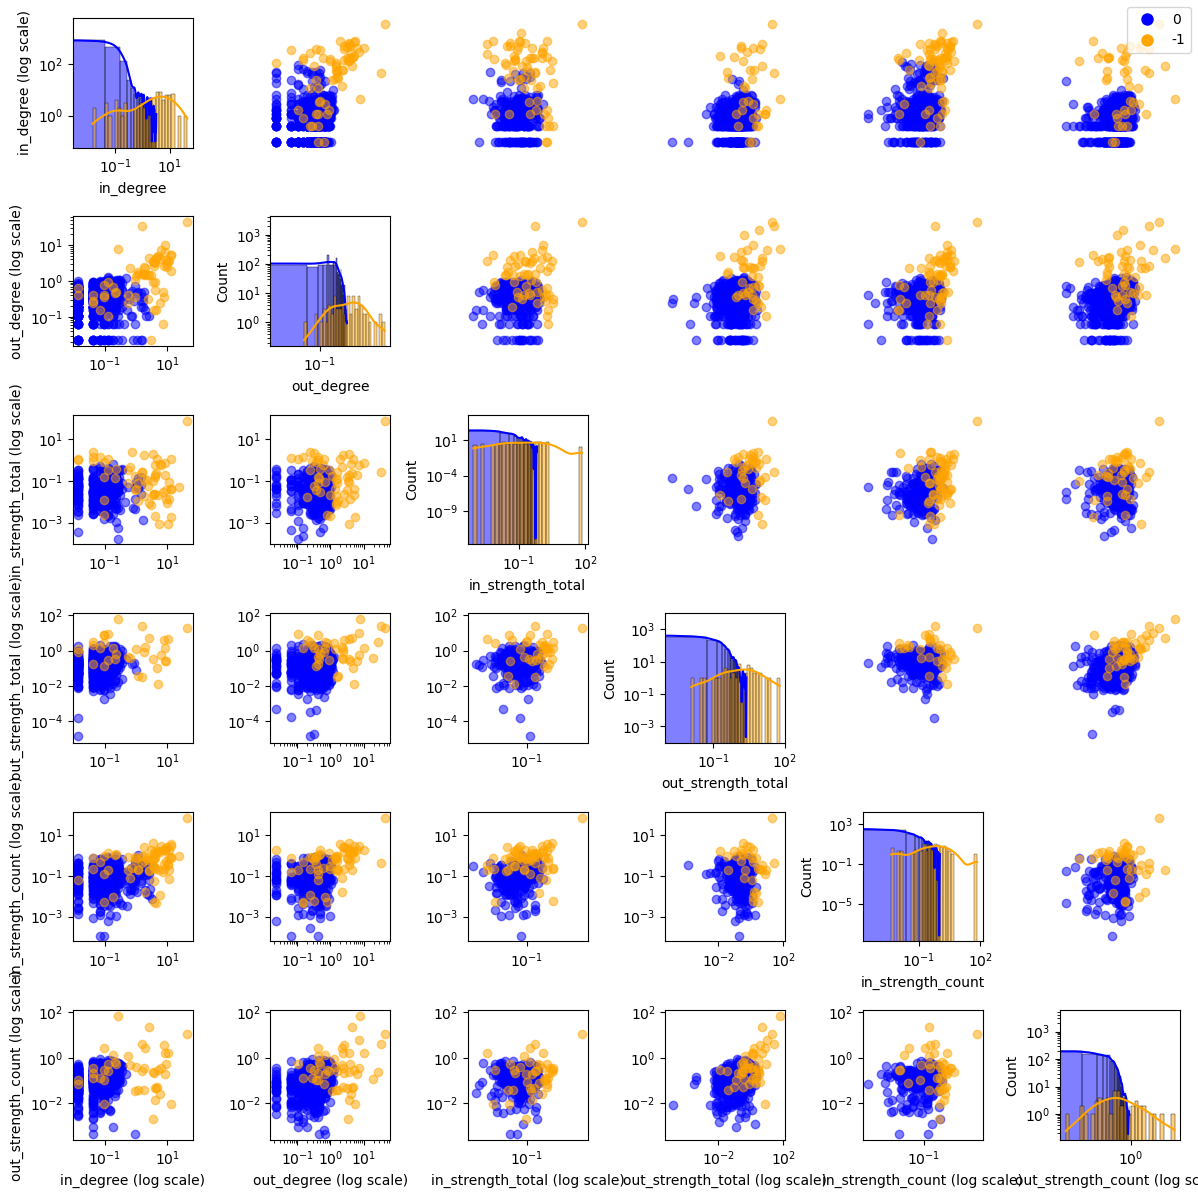

In [35]:
from itertools import combinations

def plot_pariplot(data):
    # Get column names excluding 'cluster'
    cols = data.columns[:-1]
    clusters = data['cluster'].unique()

    # Define colors for clusters
    colors = {'0': 'blue', '-1': 'orange'}
    fig, axes = plt.subplots(len(cols), len(cols), figsize=(12, 12))

    # Loop through the columns to create scatter plots for upper and lower triangles
    for i, j in combinations(range(len(cols)), 2):
        for cluster in clusters:
            cluster_data = data[data['cluster'] == cluster]
            axes[i, j].scatter(cluster_data[cols[j]], cluster_data[cols[i]], alpha=0.5, label=cluster, color=colors[str(cluster)])
            axes[j, i].scatter(cluster_data[cols[i]], cluster_data[cols[j]], alpha=0.5, color=colors[str(cluster)])
            axes[i, j].set_xscale('log')
            axes[i, j].set_yscale('log')
            axes[j, i].set_xscale('log')
            axes[j, i].set_yscale('log')

    # Diagonal histograms and KDE
    for i in range(len(cols)):
        for cluster in clusters:
            sns.histplot(data[data['cluster'] == cluster][cols[i]], bins=30, kde=True, ax=axes[i, i], color=colors[str(cluster)], alpha=0.5)
            axes[i, i].set_xscale('log')
            axes[i, i].set_yscale('log')

    # Set labels
    for i in range(len(cols)):
        for j in range(len(cols)):
            if i == len(cols) - 1:
                axes[i, j].set_xlabel(cols[j])
            if j == 0:
                axes[i, j].set_ylabel(cols[i])

    # Remove empty subplots in the lower triangle
    for i in range(len(cols)):
        for j in range(len(cols)):
            if i < j:
                axes[i, j].axis('off')

    # Add legend to the plot
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[str(cluster)], markersize=10) for cluster in clusters]
    labels = clusters
    fig.legend(handles, labels, loc='upper right')

    # Adjust the layout
    plt.tight_layout()
    plt.show()

plot_pariplot(normalized_features_df)